In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


## Question 1

# Black-Sholes-Merton

In [7]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [9]:
euro_option_bs(200, 250, 0.75, 0.05, 0.25, 'call')

5.13728677600556

In [29]:
S = np.linspace(150,300,11)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 100, 0.75, 0.05, 0.25, 'call')

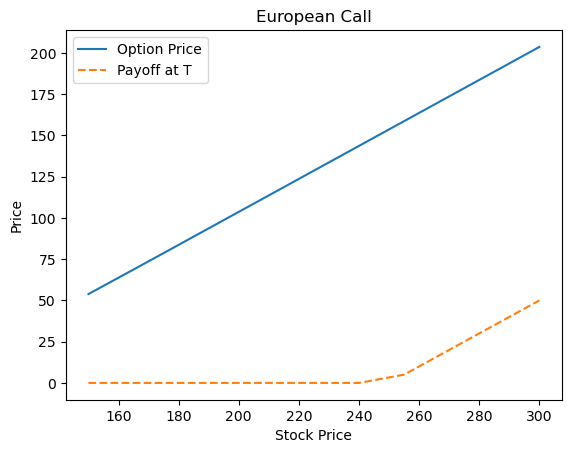

In [31]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-250,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

# Monte Carlo Simulation

In [17]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])    
        # Price process, see Hilpisch (2015) chapter 1 (equation 1-1) & chapter 3 (equation 3-6)
    return S

In [19]:
T = 0.75
r = 0.05
sigma = 0.25
S0 = 200
K = 250

In [21]:
S = mcs_simulation_np(1000)

In [23]:
S = np.transpose(S)
S

array([[200.        , 201.16571858, 199.79984572, ..., 147.74720808,
        147.75137588, 148.56173811],
       [200.        , 200.01453267, 202.23184243, ..., 195.11089385,
        192.94376119, 194.65080509],
       [200.        , 200.1074729 , 197.73056067, ..., 157.32511144,
        156.04728424, 155.22232522],
       ...,
       [200.        , 199.88641944, 199.6242287 , ..., 205.60223017,
        203.47327863, 203.56407313],
       [200.        , 198.7574901 , 198.67602004, ..., 219.31713208,
        217.41351447, 214.3431085 ],
       [200.        , 201.52627487, 201.14984606, ..., 199.59768101,
        197.16792845, 196.37090831]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

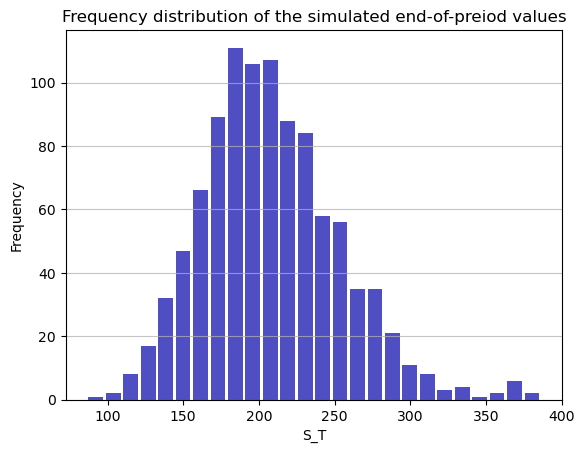

In [25]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [27]:
c = np.exp(-r*T)*np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 5.139594542564453


## Question 2

### 2c

In [37]:
Google = yf.download("GOOG", start="2023-11-25", end="2024-11-25")
Google. tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2024-11-18 00:00:00+00:00,176.599655,176.800003,176.910004,174.419998,174.955002,18725400
2024-11-19 00:00:00+00:00,179.376495,179.580002,180.169998,175.115997,175.235001,15392900
2024-11-20 00:00:00+00:00,177.129044,177.330002,179.110001,175.330002,178.830002,15729800
2024-11-21 00:00:00+00:00,169.048218,169.240005,175.580002,165.309998,175.455002,38839400
2024-11-22 00:00:00+00:00,166.381256,166.570007,168.264999,165.710007,167.160004,24497000


In [39]:
S = Google['Adj Close'].iloc[-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ Ticker
GOOG    166.38
Name: 2024-11-22 00:00:00+00:00, dtype: float64 .


### Newton-Raphson iteration to estimate the implied volatility 

In [46]:
def newton_vol_call(S, K, T, C, r):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: risk free rate
    #sigma: volatility of underlying asset
   
    MAX_ITERATIONS = 1000
    tolerance = 0.000001
    
    sigma = 0.25
    
    for i in range(0, MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)

        diff = C - price

        if (abs(diff) < tolerance):
            return sigma
        else: 
            sigma = sigma + diff/vega
        
        # print(i,sigma,diff)
        
    return sigma

In [120]:
Google_opt = yf.Ticker("GOOG")
opt = Google_opt.option_chain('2024-12-13')
opt.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOG241213C00100000,2024-12-06 20:59:24+00:00,100.0,76.54,0.0,0.0,0.0,0.0,1.0,42,0.000010,True,REGULAR,USD
1,GOOG241213C00115000,2024-12-06 19:55:51+00:00,115.0,60.94,0.0,0.0,0.0,0.0,1.0,1,0.000010,True,REGULAR,USD
2,GOOG241213C00125000,2024-11-21 14:30:04+00:00,125.0,50.53,0.0,0.0,0.0,0.0,NaN,0,0.000010,True,REGULAR,USD
3,GOOG241213C00130000,2024-11-25 20:50:00+00:00,130.0,39.70,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
4,GOOG241213C00135000,2024-11-22 15:28:54+00:00,135.0,32.05,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD
5,GOOG241213C00140000,2024-12-02 15:43:35+00:00,140.0,33.15,0.0,0.0,0.0,0.0,1.0,4,0.000010,True,REGULAR,USD
6,GOOG241213C00145000,2024-12-06 17:21:31+00:00,145.0,31.24,0.0,0.0,0.0,0.0,2.0,0,0.000010,True,REGULAR,USD
7,GOOG241213C00147000,2024-12-02 20:54:10+00:00,147.0,26.25,0.0,0.0,0.0,0.0,NaN,0,0.000010,True,REGULAR,USD
8,GOOG241213C00148000,2024-12-03 18:46:58+00:00,148.0,24.80,0.0,0.0,0.0,0.0,NaN,2,0.000010,True,REGULAR,USD
9,GOOG241213C00149000,2024-12-06 19:19:39+00:00,149.0,27.08,0.0,0.0,0.0,0.0,3.0,4,0.000010,True,REGULAR,USD


In [171]:
impvol = newton_vol_call(float(S), 185, 1/12, float(opt.calls.lastPrice[opt.calls.strike == 185.00].iloc[0]), 0.0353)
print('The implied volatility is', round(impvol*100,2) , '% for the one-month call with strike $ 185.00' )

The implied volatility is 34.75 % for the one-month call with strike $ 185.00


### 2d

In [207]:
TSLA = yf.download("TSLA", start="2024-01-03", end="2025-01-03")

[*********************100%***********************]  1 of 1 completed


In [327]:
TSLA_opt = yf.Ticker("TSLA")
opt = TSLA_opt.option_chain('2025-01-03')
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA250103P00075000,2024-12-06 19:59:36+00:00,75.0,0.01,0.00,0.07,0.0,0.0,2.0,4,2.281254,False,REGULAR,USD
1,TSLA250103P00090000,2024-11-25 19:01:49+00:00,90.0,0.03,0.01,0.38,0.0,0.0,NaN,1,2.421879,False,REGULAR,USD
2,TSLA250103P00100000,2024-12-10 16:28:41+00:00,100.0,0.03,0.02,0.19,0.0,0.0,25.0,26,2.117192,False,REGULAR,USD
3,TSLA250103P00115000,2024-12-09 20:06:22+00:00,115.0,0.05,0.00,0.33,0.0,0.0,950.0,975,2.011724,False,REGULAR,USD
4,TSLA250103P00125000,2024-12-06 15:26:02+00:00,125.0,0.09,0.00,0.22,0.0,0.0,1.0,1,1.808595,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,TSLA250103P00570000,2024-11-22 15:35:40+00:00,570.0,225.20,145.10,147.30,0.0,0.0,1.0,0,0.632328,True,REGULAR,USD
82,TSLA250103P00620000,2024-12-02 15:32:11+00:00,620.0,263.50,194.25,196.45,0.0,0.0,NaN,0,0.587895,True,REGULAR,USD
83,TSLA250103P00640000,2024-12-05 16:10:13+00:00,640.0,269.75,213.95,217.40,0.0,0.0,NaN,0,0.736819,True,REGULAR,USD
84,TSLA250103P00660000,2024-12-03 15:17:57+00:00,660.0,306.20,233.95,237.40,0.0,0.0,NaN,0,0.783205,True,REGULAR,USD


In [329]:
S = TSLA['Adj Close'].iloc[-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ Ticker
TSLA    404.96
Name: 2024-12-10 00:00:00+00:00, dtype: float64 .


In [331]:
c = mibian.BS([S, 140.00, 5, 39], putPrice = opt.puts.lastPrice[opt.puts.strike == 140.00].iloc[0])
c.impliedVolatility
print('The implied volatility is', round(c.impliedVolatility,2) , '% for the 17th of January 2025 put with strike $ 140.00' )

The implied volatility is 115.23 % for the 17th of January 2025 put with strike $ 140.00


C:\Users\hp\anaconda3\Lib\site-packages\mibian\__init__.py:256: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.underlyingPrice = float(args[0])


In [333]:
c = mibian.BS([S, 340.00, 5, 39], putPrice = opt.puts.lastPrice[opt.puts.strike == 340.00].iloc[0])
c.impliedVolatility
print('The implied volatility is', round(c.impliedVolatility,2) , '% for the 17th of January 2025 put with strike $ 340.00' )

The implied volatility is 42.91 % for the 17th of January 2025 put with strike $ 340.00


### 2e

In [223]:
# Calculate log returns
TSLA['Log Return'] = np.log(TSLA['Adj Close'] / TSLA['Adj Close'].shift(1))

# Calculate daily volatility (standard deviation of log returns)
daily_volatility_log = TSLA['Log Return'].std()

# Annualize the daily volatility (assuming 252 trading days per year)
annual_volatility_log = daily_volatility_log * np.sqrt(252)

# Print the log annualized volatility
print(f"Annual Historical Volatility of Tesla (Log Returns): {annual_volatility_log * 100:.2f}%")

Annual Historical Volatility of Tesla (Log Returns): 61.97%


### Question 3

In [ ]:
Binomial Tree

In [323]:
import numpy as np
import os

In [251]:
S0 = 100.0              # spot stock price
K = 100.0               # strike
T = 1.0                 # maturity 
r = 0.05                 # risk free rate 
sig = 0.2               # standard deviation (volatility)
N = 3                   # number of periods or number of time steps  
payoff = "call"          # payoff 

In [253]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [311]:
round (u,2), round (d,2)


(1.12, 0.89)

In [257]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1): #looping forwards, from 1 to N
    for i in range(z):  #looping forwards, from 0 to z-1
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1  # same as z=z+1

In [259]:
S

array([[100.        , 112.24009024, 125.97837858, 141.39824581],
       [  0.        ,  89.09472523, 100.        , 112.24009024],
       [  0.        ,   0.        ,  79.37870064,  89.09472523],
       [  0.        ,   0.        ,   0.        ,  70.72223522]])

In [313]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
round (p,2),round (q,2)

(0.54, 0.46)

### Step 2: Find option value at each final node

In [315]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
V

array([[ 0.        ,  0.        ,  0.        , 41.39824581],
       [ 0.        ,  0.        ,  0.        , 12.24009024],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

### Step 3: Find option value at earlier nodes

In [317]:
# for American Option
# for American Option
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])) 
            #compare the payoffs from early exercise with the theoretical option value. 
V

array([[11.04387109, 17.71388824, 27.6312332 , 41.39824581],
       [ 0.        ,  3.50065379,  6.54586268, 12.24009024],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [295]:
print('American ' + payoff, str( V[0,0]))

American call 11.043871091951113
